### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("Attention is all you need")

'Page: Attention Is All You Need\nSummary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi'

In [6]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [9]:
## tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\HP\AppData\Local\Temp\ipykernel_24772\2071343940.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("What is the latest news about AI?")

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business ...',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide.',
  'score': 0.78014404},
 {'title': 'AI News & Artificial Intelligence',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': 'Contact Us\n\n# AI\n\nNews coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language models, text-to-image and text-to-video models; speech recognition and generation; and predictive analytics.\n\n### \n\nDoorDash scooter\n\n### DoorDash says it banned driver who seemingly faked a delivery using AI\n\nThe Grok app on a smartphone [...] ### Topics\n\nLatest\n\nAI\n\nAmazon\n\nApps\n\nBiotech & Health\n\nClimate\n\nClou

In [ ]:
### combine all the tools in the list

tools = [arxiv,wiki,tavily]

In [16]:
## initialize my llm model

from langchain_groq import ChatGroq

## free groq model
llm = ChatGroq(model="qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [17]:
from pprint import pprint
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content=F"What is the latest news about AI?")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest news about AI. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided are arxiv, wikipedia, and tavily_search_results_json. Arxiv is for scientific papers, which might not be the best for current news. Wikipedia is good for general information but might not have the most up-to-date news. The third option is tavily_search_results_json, which is described as a search engine optimized for current events. That sounds like the right choice here since the user wants the latest news. \n\nSo I should call tavily_search_results_json with the query "latest news about AI". I need to make sure the parameters are correctly formatted. The required parameter is "query", and the input should be a string. \n\nI\'ll structure the tool call accordingly. Let me double-check the function\'s description to ensure it\'s the best fit. Yes, it\'s meant for cur

In [18]:
llm_with_tools.invoke([HumanMessage(content=F"What is the latest news about AI?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest news about AI'},
  'id': '83pv616pp',
  'type': 'tool_call'}]

In [31]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

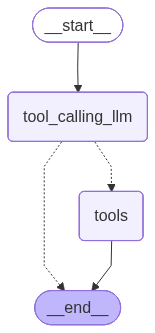

In [32]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [35]:
messages = graph.invoke({"messages":HumanMessage(content="attention is all you need")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (qs979a0kp)
 Call ID: qs979a0kp
  Args:
    query: attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [40]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me top 10 recent AI news")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b5wpwn66k)
 Call ID: b5wpwn66k
  Args:
    query: top 10 recent AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The Latest AI News and AI Breakthroughs that Matter Most: 2025", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Date: December 10, 2025 Summary: Google has expanded its AI lineup with the release of Gemini 3 Flash, a lightweight model optimized for speed and efficiency at scale. Designed for developers requiring low-latency responses, the new model features a massive context window while significantly reducing operational costs. Google claims the Flash variant is ideal for real-time applications like live translation, rapid c

In [39]:
messages = graph.invoke({"messages":HumanMessage(content="what is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to learn patterns and make decisions from data without being explicitly programmed. Instead of relying on rigid instructions, machine learning systems improve their performance over time by analyzing examples and experiences.

### Key Concepts:
1. **Supervised Learning**: Uses labeled datasets to train models (e.g., predicting house prices based on historical data).
2. **Unsupervised Learning**: Discovers hidden patterns in unlabeled data (e.g., clustering customers by behavior).
3. **Reinforcement Learning**: Learns by interacting with an environment through trial and error, guided by rewards/penalties (e.g., training a robot to walk).

### Applications:
- I